In [1]:
import pandas as pd

df = pd.read_csv("SeoulBikeDataClean.csv", parse_dates=["datetime"])

df = df[df['functioning_day'] == 'Yes'].copy()

df['target'] = df['rented_bike_count']

train_df = df[df['datetime'] < '2018-10-01']
val_df   = df[(df['datetime'] >= '2018-10-01') & (df['datetime'] < '2018-11-01')]
test_df  = df[df['datetime'] >= '2018-11-01']

print(" Data loaded and split.")


 Data loaded and split.


In [2]:
# Train XGBoost model with updated feature set

import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Updated feature list to match cleaned dataset
all_features = [
    'hour', 'temperaturec', 'humiditypct', 'wind_speed_m_s', 'visibility_10m',
    'dew_point_temperaturec', 'solar_radiation_mj_m2', 'rainfallmm', 'snowfall_cm',
    'seasons', 'holiday', 'weekday', 'month', 'time_bin',
    'is_raining', 'is_snowing', 'temperaturec_squared',
    'is_weekend', 'is_holiday', 'is_working_day',
    'temp_rain', 'temp_snow', 'humid_rain'
]

# Separate numeric and categorical columns
numeric_features = [
    'temperaturec', 'humiditypct', 'wind_speed_m_s', 'visibility_10m',
    'dew_point_temperaturec', 'solar_radiation_mj_m2',
    'rainfallmm', 'snowfall_cm', 'temperaturec_squared',
    'temp_rain', 'temp_snow', 'humid_rain'
]
categorical_features = list(set(all_features) - set(numeric_features))

# Build datasets
X_train = train_df[all_features]
y_train = train_df['target']
X_val   = val_df[all_features]
y_val   = val_df['target']

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)

# DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_proc, label=y_train)
dval   = xgb.DMatrix(X_val_proc, label=y_val)

# XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eta': 0.05,
    'max_depth': 6,
    'eval_metric': 'rmse',
    'seed': 42
}

watchlist = [(dtrain, 'train'), (dval, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=watchlist,
    early_stopping_rounds=10
)

print("✅ Model training complete with updated features.")



[0]	train-rmse:627.89875	eval-rmse:660.90045
[1]	train-rmse:603.66151	eval-rmse:644.57627
[2]	train-rmse:580.88455	eval-rmse:630.62730
[3]	train-rmse:559.19508	eval-rmse:616.67661
[4]	train-rmse:538.86708	eval-rmse:604.00698
[5]	train-rmse:519.59701	eval-rmse:592.12690
[6]	train-rmse:501.58348	eval-rmse:580.11706
[7]	train-rmse:484.61850	eval-rmse:570.13193
[8]	train-rmse:468.69297	eval-rmse:562.02352
[9]	train-rmse:453.57092	eval-rmse:551.10413
[10]	train-rmse:439.58219	eval-rmse:542.88710
[11]	train-rmse:426.39658	eval-rmse:534.05062
[12]	train-rmse:413.02223	eval-rmse:528.00996
[13]	train-rmse:401.17479	eval-rmse:521.90861
[14]	train-rmse:389.40375	eval-rmse:518.01539
[15]	train-rmse:378.40851	eval-rmse:512.25654
[16]	train-rmse:368.03356	eval-rmse:506.91419
[17]	train-rmse:358.47773	eval-rmse:502.36140
[18]	train-rmse:349.87598	eval-rmse:497.24927
[19]	train-rmse:341.39298	eval-rmse:494.28043
[20]	train-rmse:333.22976	eval-rmse:487.62720
[21]	train-rmse:325.25413	eval-rmse:483.9382

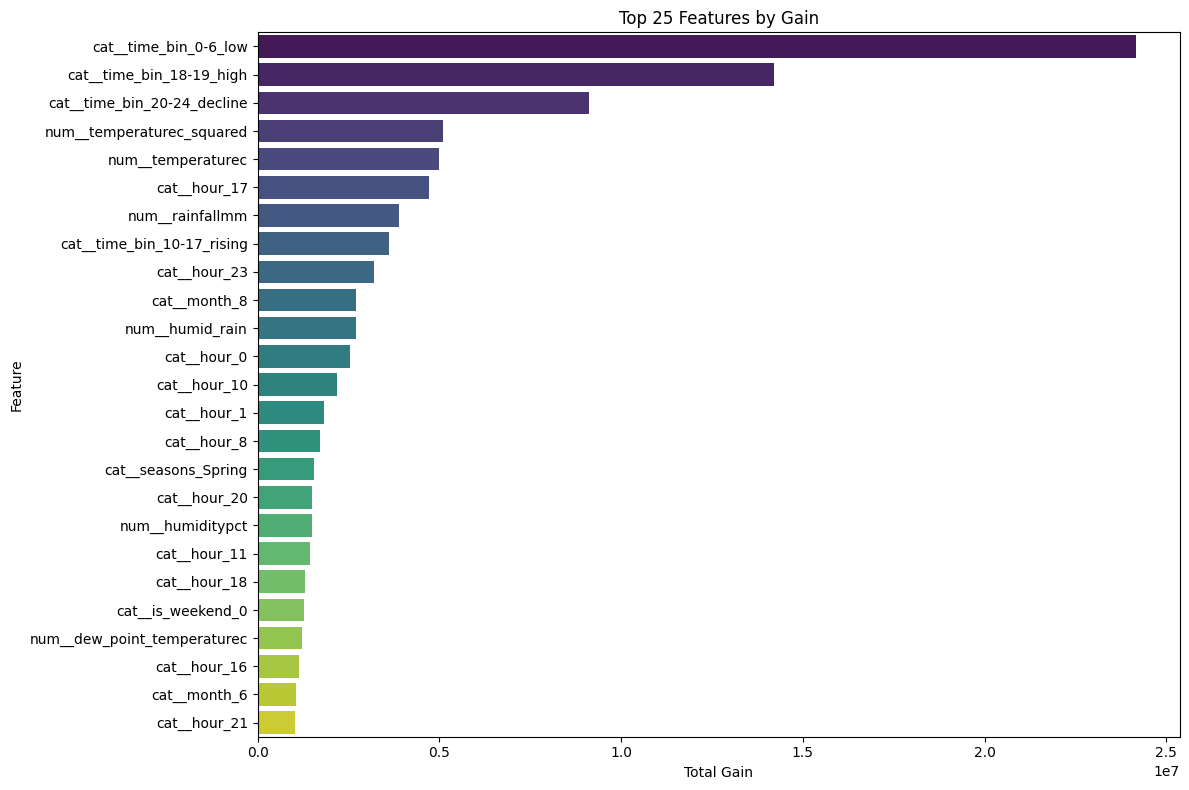

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = preprocessor.get_feature_names_out()

raw_importance = xgb_model.get_score(importance_type='gain')

mapped_importance = []
for i, fname in enumerate(feature_names):
    fid = f"f{i}"
    gain = raw_importance.get(fid, 0)
    mapped_importance.append((fname, gain))

importance_df = pd.DataFrame(mapped_importance, columns=['feature', 'gain'])
importance_df = importance_df.sort_values(by='gain', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(25), x='gain', y='feature', palette='viridis')
plt.title("Top 25 Features by Gain")
plt.xlabel("Total Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



Validation RMSE: 395.23, R²: 0.5959
Test RMSE:       365.54, R²: 0.3559


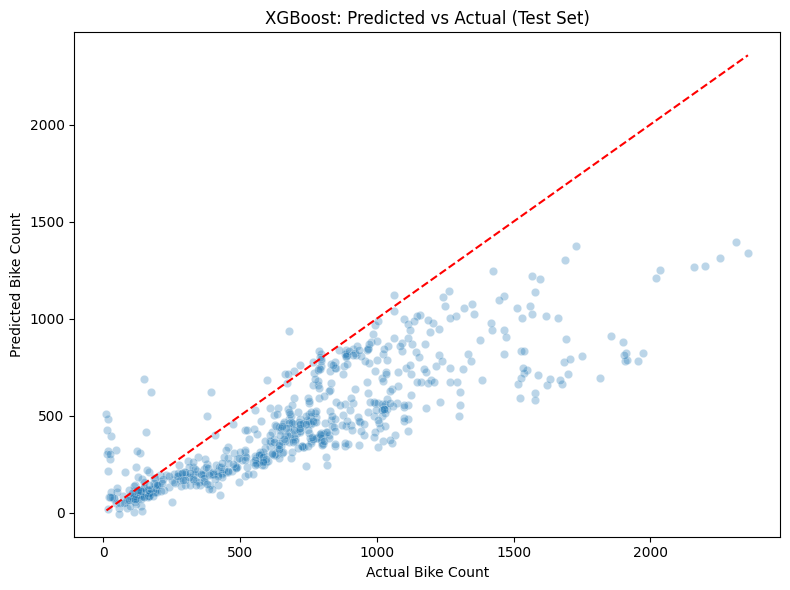

In [4]:
# Evaluate XGBoost on validation and test set

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

X_val_proc  = preprocessor.transform(val_df[all_features])
X_test_proc = preprocessor.transform(test_df[all_features])
y_val_true  = val_df['target']
y_test_true = test_df['target']

dval_final  = xgb.DMatrix(X_val_proc)
dtest_final = xgb.DMatrix(X_test_proc)

y_val_pred  = xgb_model.predict(dval_final)
y_test_pred = xgb_model.predict(dtest_final)

rmse_val = mean_squared_error(y_val_true, y_val_pred, squared=False)
r2_val   = r2_score(y_val_true, y_val_pred)

rmse_test = mean_squared_error(y_test_true, y_test_pred, squared=False)
r2_test   = r2_score(y_test_true, y_test_pred)

print(f"Validation RMSE: {rmse_val:.2f}, R²: {r2_val:.4f}")
print(f"Test RMSE:       {rmse_test:.2f}, R²: {r2_test:.4f}")

# 可视化 Test 散点图
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_true, y=y_test_pred, alpha=0.3)
plt.plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'r--')
plt.xlabel("Actual Bike Count")
plt.ylabel("Predicted Bike Count")
plt.title("XGBoost: Predicted vs Actual (Test Set)")
plt.tight_layout()
plt.show()


IQR upper bound for outliers: 1927.88
Points with actual > 1000: 157 (24.23% of test set)
Points above IQR outlier bound: 9 (1.39% of test set)


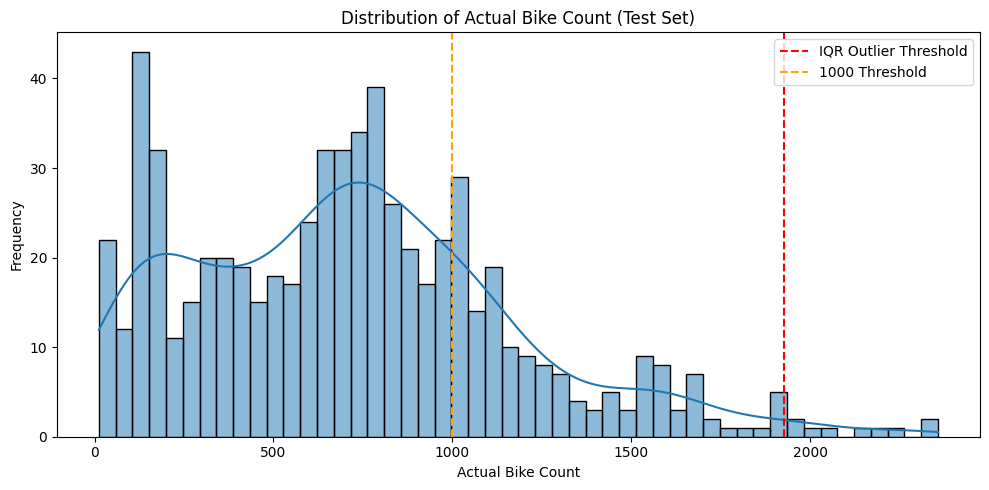

In [5]:
Q1 = np.percentile(y_test_true, 25)
Q3 = np.percentile(y_test_true, 75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

print(f"IQR upper bound for outliers: {upper_bound:.2f}")

num_total = len(y_test_true)
num_gt1000 = np.sum(y_test_true > 1000)
num_outlier_iqr = np.sum(y_test_true > upper_bound)

print(f"Points with actual > 1000: {num_gt1000} ({num_gt1000 / num_total:.2%} of test set)")
print(f"Points above IQR outlier bound: {num_outlier_iqr} ({num_outlier_iqr / num_total:.2%} of test set)")

plt.figure(figsize=(10, 5))
sns.histplot(y_test_true, bins=50, kde=True)
plt.axvline(upper_bound, color='red', linestyle='--', label='IQR Outlier Threshold')
plt.axvline(1000, color='orange', linestyle='--', label='1000 Threshold')
plt.title("Distribution of Actual Bike Count (Test Set)")
plt.xlabel("Actual Bike Count")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

